The goal is modeling a scenario in which a seller exploits advertising tools to attract more and more users to its website, thus increasing the number of possible buyers. The seller needs to learn simultaneously the conversion rate and the number of users the advertising tools can attract.

1) Imagine:
    - one product to sell;
    - three classes of users, where, for every user, we can observe the values of two binary features (feel free to choose the features and their domains);
    - the conversion rate curve of each class of users;
    - three subcampaigns, each with a different ad, to advertise the product, and each targeting a different class of users;
    - there are three abrupt phases;
    - for every abrupt phase and for every subcampaign, the probability distribution over the daily number of clicks for every value of budget allocated to that subcampaign.

3) Design a sliding-window combinatorial bandit algorithm for the case, instead, in which there are the three phases aforementioned.
Plot the cumulative regret and compare it with the cumulative regret that a non-sliding-window algorithm would obtain.


9 curve, 3 fasi

In [1]:
import numpy as np
import pandas as pd

from project.dia_pckg.plot_style.cb91visuals import *
from project.part_2.Learner import Learner
from project.part_2.Optimizer import Optimizer as Ta, Optimizer
from project.part_3.AbruptBiddingEnvironment import AbruptBiddingEnvironment
from project.part_3.DynamicLearner import DynamicLearner

In [2]:
np.random.seed(72)
n_phases = 3
len_window = 40
phaselen = 60
n_obs = 180 #3 abrupt phase
print_span = 60 #ogni quanti giorni printare i grafici

init_days = 20 #primi giorni si pullano gli arm in modo casuale senza pensare al reward massimo
random_sampling = 5

n_subcamp = 3

max_bid = 1
max_clicks = 100
n_arms = 11

noise_std = 5.0

bids = np.linspace(0, max_bid, n_arms)

In [3]:
sw_total_click_each_day  = pd.DataFrame(columns=['bid_sub1', 'bid_sub2', 'bid_sub3',"click1","click2","click3"])


env = AbruptBiddingEnvironment(bids,max_clicks,noise_std,phaselen, n_phases)

sw_learners = []


for i in range(0, n_subcamp):
    sw_learners.append(DynamicLearner(n_arms,bids,len_window))

print(f'PHASES OF {env.phaselen} DAYS\n{n_obs} TOTAL OBSERVATION')



for d in range(0, n_obs):
    pulled = [0,0,0]
    #per i primi init_days giorni si pullano in modo causale, successivamente si usa la tabella
    if init_days > 0: #or d % random_sampling == 0: #or d % int(len_window/2) == 0:
        init_days = init_days - 1
        first = d % 3
        pulled[first] = sw_learners[first].pull_arm()
        pulled[(first + 1 )% 3] = np.random.randint(0,n_arms - pulled[first])
        pulled[(first + 2 )% 3] = n_arms - pulled[first] - pulled[(first + 1 )% 3] - 1
    else:
        #uso l'algoritmo della tabella per selezionare gli arm che mi danno un reward massimo
        table_all_Subs = np.ndarray(shape=(0,len(bids)), dtype=float)
        for l in sw_learners:
            table_all_Subs = np.append(table_all_Subs,np.atleast_2d(l.means.T),0)
        pulled = Ta.fit_table(table_all_Subs)[0]


    clicks = env.round(pulled[0],pulled[1],pulled[2])


    for x in range(0,n_subcamp):
        sw_learners[x].update(pulled[x], clicks[x])
    sw_total_click_each_day = sw_total_click_each_day.append({
        'bid_sub1':pulled[0],
        'bid_sub2':pulled[1],
        'bid_sub3':pulled[2],
        "click1":clicks[0],
        "click2":clicks[1],
        "click3":clicks[2]
    }, ignore_index=True)

    if (d+1) % print_span == 0:
        print(f"DAY: {d}\nPULLED:{pulled}\nCLICKS: {clicks}\nTOT: {clicks.sum()}\n")


PHASES OF 60 DAYS
180 TOTAL OBSERVATION
DAY: 59
PULLED:[7, 0, 3]
CLICKS: [90.  0. 87.]
TOT: 177.0

DAY: 119
PULLED:[3, 3, 4]
CLICKS: [103.  26.  38.]
TOT: 167.0

DAY: 179
PULLED:[7, 3, 0]
CLICKS: [102.  50.   0.]
TOT: 152.0



In [4]:
total_click_each_day  = pd.DataFrame(columns=['bid_sub1', 'bid_sub2', 'bid_sub3',"click1","click2","click3"])
env = AbruptBiddingEnvironment(bids,max_clicks,noise_std,phaselen, n_phases)
init_days = 20
learners = []

for i in range(0, n_subcamp):
    learners.append(Learner(n_arms,bids))

for d in range(0, n_obs):
    pulled = [0,0,0]
    #per i primi init_days giorni si pullano in modo causale, successivamente si usa la tabella
    if init_days > 0 or d % random_sampling == 0:
        init_days = init_days - 1
        first = d % 3
        pulled[first] = learners[first].pull_arm()
        pulled[(first + 1 )% 3] = np.random.randint(0,n_arms - pulled[first])
        pulled[(first + 2 )% 3] = n_arms - pulled[first] - pulled[(first + 1 )% 3] - 1
    else:
        #uso l'algoritmo della tabella per selezionare gli arm che mi danno un reward massimo
        table_all_Subs = np.ndarray(shape=(0,len(bids)), dtype=float)
        for l in learners:
            table_all_Subs = np.append(table_all_Subs,np.atleast_2d(l.means.T),0)
        pulled = Ta.fit_table(table_all_Subs)[0]


    clicks = env.round(pulled[0],pulled[1],pulled[2])


    for x in range(0,n_subcamp):
        learners[x].update(pulled[x], clicks[x])
    total_click_each_day = total_click_each_day.append({
        'bid_sub1':pulled[0],
        'bid_sub2':pulled[1],
        'bid_sub3':pulled[2],
        "click1":clicks[0],
        "click2":clicks[1],
        "click3":clicks[2]
    }, ignore_index=True)

    if (d+1) % print_span == 0:
        #TIME TO PRINT THE PLOTS
        print(f"DAY: {d}\nPULLED:{pulled}\nCLICKS: {clicks}\nTOT: {clicks.sum()}\n")

DAY: 59
PULLED:[7, 0, 3]
CLICKS: [ 89.   0. 100.]
TOT: 189.0

DAY: 119
PULLED:[4, 1, 5]
CLICKS: [101.  10.  45.]
TOT: 156.0

DAY: 179
PULLED:[6, 1, 3]
CLICKS: [117.  26.   0.]
TOT: 143.0



In [5]:
basic_total_click_each_day  = pd.DataFrame(columns=['bid_sub1', 'bid_sub2', 'bid_sub3',"click1","click2","click3"])
env = AbruptBiddingEnvironment(bids,max_clicks,noise_std,phaselen, n_phases)
init_days = 20
learners = []

for i in range(0, n_subcamp):
    learners.append(Learner(n_arms,bids))

for d in range(0, n_obs):
    pulled = [0,0,0]
    #per i primi init_days giorni si pullano in modo causale, successivamente si usa la tabella
    if init_days > 0: #or d % random_sampling == 0: #or d % int(len_window/2) == 0:
        init_days = init_days - 1
        first = d % 3
        pulled[first] = learners[first].pull_arm()
        pulled[(first + 1 )% 3] = np.random.randint(0,n_arms - pulled[first])
        pulled[(first + 2 )% 3] = n_arms - pulled[first] - pulled[(first + 1 )% 3] - 1
    else:
        #uso l'algoritmo della tabella per selezionare gli arm che mi danno un reward massimo
        table_all_Subs = np.ndarray(shape=(0,len(bids)), dtype=float)
        for l in learners:
            table_all_Subs = np.append(table_all_Subs,np.atleast_2d(l.means.T),0)
        pulled = Ta.fit_table(table_all_Subs)[0]


    clicks = env.round(pulled[0],pulled[1],pulled[2])


    for x in range(0,n_subcamp):
        learners[x].update(pulled[x], clicks[x])
    basic_total_click_each_day = basic_total_click_each_day.append({
        'bid_sub1':pulled[0],
        'bid_sub2':pulled[1],
        'bid_sub3':pulled[2],
        "click1":clicks[0],
        "click2":clicks[1],
        "click3":clicks[2]
    }, ignore_index=True)

    if (d+1) % print_span == 0:
        #TIME TO PRINT THE PLOTS
        print(f"DAY: {d}\nPULLED:{pulled}\nCLICKS: {clicks}\nTOT: {clicks.sum()}\n")





DAY: 59
PULLED:[8, 0, 2]
CLICKS: [99.  0. 88.]
TOT: 187.0

DAY: 119
PULLED:[6, 2, 2]
CLICKS: [102.  26.  16.]
TOT: 144.0

DAY: 179
PULLED:[6, 2, 2]
CLICKS: [93. 32.  0.]
TOT: 125.0



/Users/08volt/PycharmProjects/DataIntelligenceApplications/venv/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


190.0
165.0
170.0


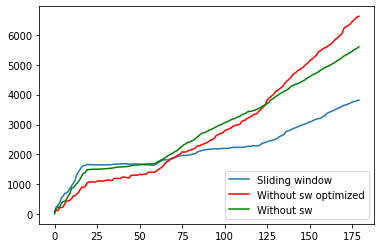

In [6]:
clicks_opt = np.array([])

for p in range(0,n_phases):
    all_optimal_subs = np.ndarray(shape=(0,len(bids)), dtype=float)
    for i in range(0,n_subcamp):
        all_optimal_subs = np.append(all_optimal_subs,np.atleast_2d(env.subs[i](bids,p)),0)
    opt = Optimizer.fit_table(all_optimal_subs)[1]
    for days in range(0,phaselen):
        clicks_opt = np.append(clicks_opt, opt)




sw_clicks_obtained = sw_total_click_each_day["click1"] + \
                  sw_total_click_each_day["click2"] + \
                  sw_total_click_each_day["click3"]

clicks_obtained = total_click_each_day["click1"] + \
                  total_click_each_day["click2"] + \
                  total_click_each_day["click3"]

basic_clicks_obtained = basic_total_click_each_day["click1"] + \
                  basic_total_click_each_day["click2"] + \
                  basic_total_click_each_day["click3"]


np.cumsum(clicks_opt - sw_clicks_obtained).plot(label="Sliding window")
np.cumsum(clicks_opt - clicks_obtained).plot(color="red", label="Without sw optimized")
np.cumsum(clicks_opt - basic_clicks_obtained).plot(color="green", label="Without sw")
plt.legend(loc='lower right')
plt.show()

plt.show()


In [7]:
print("SLIDING WINDOWS")
print(sum(sw_clicks_obtained))

print("\n\nOPTIMIZED WITHOUT SLIDING WINDOWS")
print(sum(clicks_obtained))

print("\n\nWITHOUT SLIDING WINDOWS")
print(sum(basic_clicks_obtained))

SLIDING WINDOWS
27678.0


OPTIMIZED WITHOUT SLIDING WINDOWS
24877.0


WITHOUT SLIDING WINDOWS
25899.0
